<a href="https://colab.research.google.com/github/KuKuOOOOOO/ChineseNameDection/blob/main/ChineseDection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting file...
Done.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 32, 32, 128)       1280      
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/67 [==============================] - 22s 144ms/step - loss: 0.3815 - accuracy: 0.1022 - val_loss: 0.3246 - val_accuracy: 0.1220 - lr: 3.0000e-04
Epoch 2/20
67/67 [==============================] - 8s 123ms/step - loss: 0.3255 - accuracy: 0.1405 - val_loss: 0.3167 - val_accuracy: 0.1793 - lr: 3.0000e-04
Epoch 3/20
67/67 [==============================] - 8s 122ms/step - loss: 0.3091 - accuracy: 0.2180 - val_loss: 0.2990 - val_accuracy: 0.2267 - lr: 3.0000e-04
Epoch 4/20
67/67 [==============================] - 9s 131ms/step - loss: 0.2674 - accuracy: 0.3561 - val_loss: 0.2408 - val_accuracy: 0.4227 - lr: 3.0000e-04
Epoch 5/20
67/67 [==============================] - 8s 123ms/step - loss: 0.2109 - accuracy: 0.5204 - val_loss: 0.1879 - val_accuracy: 0.5940 - lr: 3.0000e-04
Epoch 6/20
67/67 [==============================] - 8s 123ms/step - loss: 0.1539 - accuracy: 0.6788 - val_loss: 0.1385 - val_accuracy: 0.7133 - lr: 3.0000e-04
Epoch 7/20
67/67 [==============================] - 8s 1

ValueError: ignored

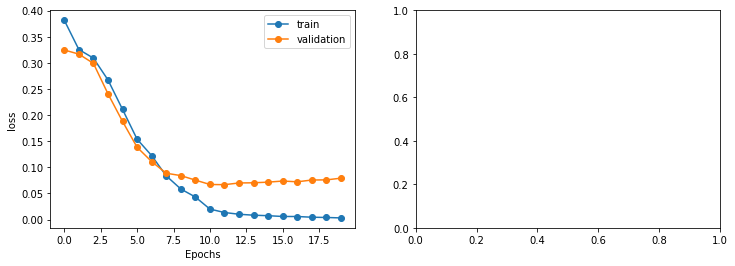

In [ ]:
img_url='https://github.com/KuKuOOOOOO/processed_img/archive/master.zip'
 
import urllib
import urllib.request
import zipfile

print('Downloading file...')
urllib.request.urlretrieve(img_url,'processed_img-master.zip')
print('Downloading Success')
print('Extracting file...')
with zipfile.ZipFile('processed_img-master.zip','r') as file:
    file.extractall('')
print('Done.')
# 匯入相關所需的模組
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import glob
import time
from random import shuffle
from collections import Counter

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils

#字-Label encoding
Chinese_data = {0:'HONG',1:'WEI',2:'FENG1',3:'FENG2',4:'XIANG',5:'LIAN',6:'NING',7:'HAO',8:'YU',9:'MING'}

img_width = 32   #image長
img_height = 32  #image寬
num_class = len(Chinese_data) # 辨識字種類
img_per_class = 1000 # 每個字將近500張訓練圖像
test_size = 0.15 #測試分割%數

#將訓練圖檔從檔案取出並轉成陣列
def load_data():
    path = './processed_img-master/'
    images = []
    labels = []
    for k,v in Chinese_data.items(): #k:數字編碼,v:字label
        # 把某一個字在檔案夾裡的所有圖像檔的路徑捉出來
        image = [k for k in glob.glob(path + v + "/*.jpg")]
        print(v + ":" + str(len(image)))
        for i,img in enumerate(image):
            tmp_img = cv2.imread(img)
            tmp_img = cv2.cvtColor(tmp_img,cv2.COLOR_BGR2GRAY)
            ret,tmp_img=cv2.threshold(tmp_img,127,255,cv2.THRESH_BINARY)
            tmp_img = cv2.resize(tmp_img,(img_height,img_width))
            images.append(tmp_img)
            labels.append(k)
    data = np.array(images)
    labels = np.array(labels)
    return data, labels

#取得訓練資料及驗證資料
def get_dataset(save=False,load=False):
    if load:
        # 從檔案系統中載入之前處理保存的訓練資料集與驗證資料集
        h5f = h5py.File('dataset.h5','r')
        x_train = h5f['x_train'][:]
        x_test = h5f['x_test'][:]
        h5f.close()

        # 從檔案系統中載入之前處理保存的訓練資料標籤與驗證資料集籤
        h5f = h5py.File('labels.h5', 'r')
        y_train = h5f['y_train'][:]
        y_test = h5f['y_test'][:]
        h5f.close()
    else:
        #從最原始圖檔開始整理
        x,y = load_data()
        y = keras.utils.np_utils.to_categorical(y,num_class) # 目標的類別種類數
        # 將資料切分為訓練資料集與驗證資料集 (85% vs.  15%)
        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size)
        # 保存尚未進行歸一化的圖像數據
        if save: 
            h5f = h5py.File('dataset.h5', 'w')
            h5f.create_dataset('x_train', data=x_train)
            h5f.create_dataset('x_test', data=x_test)
            h5f.close()
            
            h5f = h5py.File('labels.h5', 'w')
            h5f.create_dataset('y_train', data=y_train)
            h5f.create_dataset('y_test', data=y_test)
            h5f.close()
    # 進行圖像每個像素值的型別轉換與歸一化處理
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape[0],img_width,img_height,1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0],img_width,img_height,1).astype('float32')
    print("Train:",x_train.shape,y_train.shape)
    print("Test:",x_test.shape,y_test.shape)

    return x_train,x_test,y_train,y_test

#建立Model
def create_model_conv(input_shape):
    model = Sequential()
    model.add(Conv2D(128,(3, 3), padding='same',kernel_initializer='he_normal', activation='relu', input_shape=input_shape))
    model.add(Conv2D(128,(3, 3), padding='same',kernel_initializer='he_normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(256,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
    model.add(Conv2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(4096, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(4096, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_class, kernel_initializer='he_normal', activation='softmax'))
    return model

model = create_model_conv((img_height,img_width,1))
model.summary()#show模型結構
x_train,x_test,y_train,y_test = get_dataset(save=True,load=False)
lr = 0.0003
import tensorflow as tf
sgd = tf.keras.optimizers.Adam(lr=lr)
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 128
epochs = 20
history = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test,y_test),verbose=1,callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint('model.h5', save_best_only=True)])

# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc')

plt.show()
y_pred = model.predict(x_test)
import seaborn as sns
sns.set()
import pandas as pd
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(Chinese_data.values())
df = pd.DataFrame(conf_mat, index=classes, columns=classes)

fig = plt.figure(figsize = (10,10))
sns.heatmap(df, annot=True, square=True, fmt='.0f', cmap="Blues")
plt.title('Simpson characters classification')
plt.xlabel('ground_truth')
plt.ylabel('prediction')

plt.show()

